# Data Scientist Associate Practical Exam Submission

Candidate: Hoang-Dung Nguyen (Nguyễn Hoàng Dũng)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

## Task 1 

For every column in the data:

**a. State whether the values match the description given in the table.**

In [2]:
# Import the dataframe
df = pd.read_csv('electric_bike_ratings_2212.csv')
df.head()

,owned,make_model,review_month,web_browser,reviewer_age,primary_use,value_for_money,overall_rating
0,1,Nielah-Eyden,Oct,Chrome,23,Commuting,5/10,18.62
1,0,Nielah-Keetra,Jun,NaN,24,Commuting,4/10,15.55
2,0,Lunna-Keetra,23-Oct,Chrome,28,Commuting,5/10,12.76
3,1,Hoang-Keetra,07-Nov,IE,41,Leisure,5/10,17.07
4,1,Lunna-Keetra,16-Sep,Chrome,33,Leisure,5/10,12.29


In [3]:
# See the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   owned            1500 non-null   int64  
 1   make_model       1500 non-null   object 
 2   review_month     1500 non-null   object 
 3   web_browser      1350 non-null   object 
 4   reviewer_age     1500 non-null   object 
 5   primary_use      1500 non-null   object 
 6   value_for_money  1500 non-null   object 
 7   overall_rating   1500 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 93.9+ KB


In [4]:
# Observe distinct values in categorical columns
for col in df.select_dtypes(['int', 'object']):
    nunique = df[col].nunique()
    unique_vals = df[col].unique().tolist()
    print(f'{col :-<30} ({nunique}) {unique_vals}')

owned------------------------- (2) [1, 0]
make_model-------------------- (6) ['Nielah-Eyden', 'Nielah-Keetra', 'Lunna-Keetra', 'Hoang-Keetra', 'Lunna-Eyden', 'Hoang-Eyden']
review_month------------------ (332) ['Oct', 'Jun', '23-Oct', '07-Nov', '16-Sep', '26-Aug', '01-Mar', '15-Mar', '09-Mar', 'Jul', '10-Nov', 'Mar', 'Apr', 'Sep', '27-Dec', '11-Nov', '07-Dec', 'Feb', 'Jan', '06-Jun', '12-Jul', '02-Aug', '23-Feb', '27-Jul', '26-Nov', '30-Apr', '31-Jul', '22-Nov', '05-Sep', '05-Dec', '21-Jul', '15-Nov', '07-Jun', '20-May', '23-Sep', '10-Sep', '19-Oct', '28-Oct', '08-Apr', '14-Feb', '28-Nov', '28-Feb', '28-Jul', '12-Apr', '25-Apr', '25-Oct', '08-Jul', '29-Mar', '22-Sep', '26-Jun', '24-May', '12-Mar', '15-Feb', '28-Aug', 'May', '16-Jun', '02-Jul', '06-Feb', '21-Jun', 'Nov', '21-Apr', '19-Jul', '31-May', '11-Aug', '14-Mar', '12-Dec', '02-Apr', '23-Aug', '11-Feb', '24-Aug', '03-Jun', '01-Apr', '24-Nov', 'Dec', '26-Mar', '22-Oct', '22-Jan', '17-Mar', '05-Oct', '20-Mar', '13-Jul', '03-Oct', '1

In [5]:
df['overall_rating'].describe()

count    1500.000000
mean       17.138907
std         2.445566
min        11.690000
25%        15.320000
50%        18.240000
75%        18.840000
max        22.760000
Name: overall_rating, dtype: float64

**My observation:**

- `owned` matches the description since there are only 0 and 1 as distinct values.
- `make_model` matches the description with the 6 possible values as mentioned.
- `review_month` does not match the description. There is record with month only while record with format `date-month` exists in the data.
- `web_browser` closely matches the description, however there is also `nan` indicating the missing value.
- `reviewer_age` contains value `-`, which may indicate a missing value, but making the parser thinks that this is a object column (integer expected).
- `primary_use` matches the description.
- `value_for_money` should be integers instead of the format `score/10`
- `overall_rating` matches the description, with the values in range [11.69, 22.76] (description accepts from 0 to 25).

**b. State the number of missing values in the column**

In [6]:
df.isna().sum()

owned                0
make_model           0
review_month         0
web_browser        150
reviewer_age         0
primary_use          0
value_for_money      0
overall_rating       0
dtype: int64

There are 150 missing values in `web_browser` column and 105 in `reviewer_age` (if `-` is considered as the missing value). The remaining columns contain all non-null values.

**c. Describe what you did to make values match the description if they did not match.**

- `review_month`: for these values with format `date-month`, I will split the date and month using the `.split(-)` function, then only take the month as the final value.
- `web_browser`: replace `nan` with `unknown`
- `reviewer_age` replace `-` with `nan`, convert it into numeric column, then fill the missing values with the average age as required.
- `value_for_money`: take `score` from the format `score/10` using `.split(/)`.

In [7]:
# Fix on the columns that does not match the description
df['owned'] = df['owned'].astype('category')
df['make_model'] = df['make_model'].astype('category')
df['review_month'] = df['review_month'].map(lambda x: x if len(x.split('-')) == 1 else x.split('-')[1])
df['review_month'] = df['review_month'].astype('category')
df['web_browser'] = df['web_browser'].replace('-', 'unknown')
df['web_browser'] = df['web_browser'].astype('category')
df['reviewer_age'] = df['reviewer_age'].replace('-', np.nan)
df['reviewer_age'] = df['reviewer_age'].astype('Int16')
df['reviewer_age'] = df['reviewer_age'].fillna(round(df['reviewer_age'].mean()))
df['primary_use'] = df['primary_use'].astype('category')
df['value_for_money'] = df['value_for_money'].map(lambda x: x.split('/')[0])
df['value_for_money'] = df['value_for_money'].astype('Int16')

## Task 2

Create a visualization that shows how many reviews were from owners and how many were not owners. Use the visualization to:

**a. State which category of the variable owned has the most number of observations**

Category `1` (owned) has the most number of observations.

**b. Explain whether the observations are balanced across categories of the variable owned**

The observations between categories are imbalanced since the heights between 2 categories are significantly different.

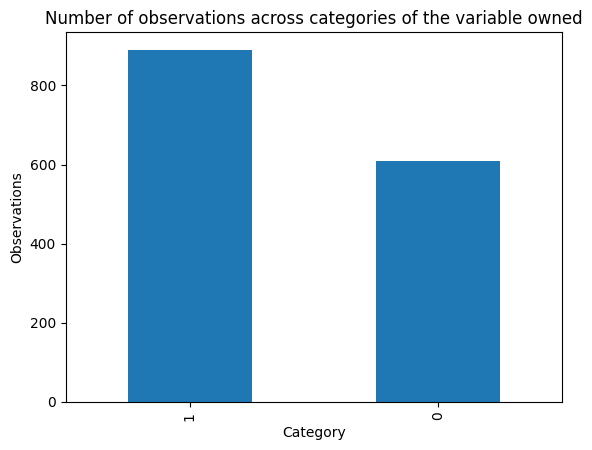

In [8]:
plt.figure()
owned_value_counts = df['owned'].value_counts()
owned_value_counts.plot.bar()
plt.title("Number of observations across categories of the variable owned")
plt.xlabel("Category")
plt.ylabel("Observations")
plt.show()

## Task 3

Describe the distribution of the overall rating across the possible values. Your answer must include a visualization that shows the distribution.

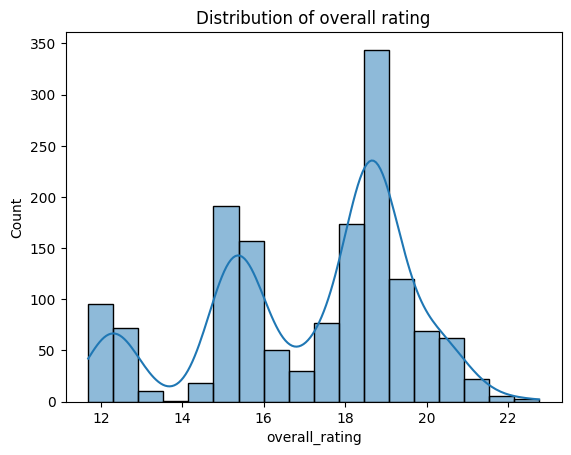

In [19]:
plt.figure()
sns.histplot(data=df, x="overall_rating", kde=True)
plt.title("Distribution of overall rating")
plt.show()

The overall rating follows a trimodal distribution, which has three distinct peaks. This means that the data is divided into three groups that have higher frequencies than the rest of the data.

## Task 4

Describe the relationship between ownership and overall rating. Your answer must include a visualization to demonstrate the relationship.

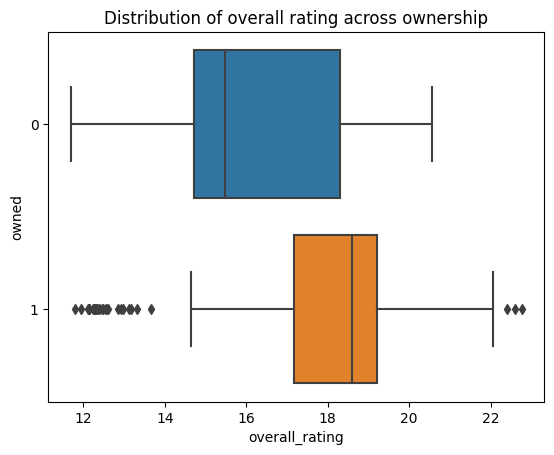

In [9]:
plt.figure()
sns.boxplot(data=df, x="overall_rating", y="owned")
plt.title("Distribution of overall rating across ownership")
plt.show()

The overall rating of reviews of the owner are likely to get higher than of the one who does not own the mopes.

## Task 5

The business wants to predict whether a review came from an owner or not using the data provided. State the type of machine learning problem that this is (regression/classification/clustering).

_My answer:_
This is a **classification problem**, where we want to map the provided features to predict the likelihood that the review came from an owner or not.

## Task 6

Fit a baseline model to predict whether a review came from an owner or not using the data provided. You must include your code.

_My answer:_

I'd be using Logistic Regression as the baseline model. About processing the data, I will keep the discrete and continuous columns, and perform One Hot Encoding (via `pd.get_dummies()`) for other categorical columns.

In [10]:
# Double check my dataframe (processed)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   owned            1500 non-null   category
 1   make_model       1500 non-null   category
 2   review_month     1500 non-null   category
 3   web_browser      1350 non-null   category
 4   reviewer_age     1500 non-null   Int16   
 5   primary_use      1500 non-null   category
 6   value_for_money  1500 non-null   Int16   
 7   overall_rating   1500 non-null   float64 
dtypes: Int16(2), category(5), float64(1)
memory usage: 29.0 KB


In [11]:
# Process the data and perform train-test split
y = df.pop('owned').values.reshape(-1, 1)
X = pd.get_dummies(df).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1050, 29)
y_train shape:  (1050, 1)
X_test shape:  (450, 29)
y_test shape:  (450, 1)


In [12]:
baseline = LogisticRegression(random_state=42)
baseline.fit(X_train, y_train)

LogisticRegression(random_state=42)

## Task 7

I will use Random Forest as the comparison model. I will also perform hyperparameter tuning for this task.

In [13]:
# Choose the type of classifier 
rf_estimator_tuned = RandomForestClassifier(criterion="entropy", random_state=42)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 7],
    'min_samples_leaf': [1, 5, 20],
    'max_features': [0.8, 0.9]
}

# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = make_scorer(f1_score, pos_label = 1)

# Run the grid search on the training data using scorer=scorer and cv=3
grid_obj = GridSearchCV(rf_estimator_tuned, param_grid, scoring = scorer, cv=3, verbose=3)
grid_obj = grid_obj.fit(X_train, y_train)

# Save the best estimator to variable comparison
comparison = grid_obj.best_estimator_

#Fit the best estimator to the training data
comparison.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=50;, score=0.777 total time=   0.1s
[CV 2/3] END max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=50;, score=0.792 total time=   0.1s
[CV 3/3] END max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=50;, score=0.770 total time=   0.1s
[CV 1/3] END max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=100;, score=0.776 total time=   0.2s
[CV 2/3] END max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=100;, score=0.790 total time=   0.2s
[CV 3/3] END max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=100;, score=0.767 total time=   0.2s
[CV 1/3] END max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=150;, score=0.771 total time=   0.2s
[CV 2/3] END max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=150;, score=0.796 total time=   0.2s
[CV 3/3] END max_depth=5, max

RandomForestClassifier(criterion='entropy', max_depth=7, max_features=0.8,
                       min_samples_leaf=20, n_estimators=50, random_state=42)

## Task 8

Explain why you chose the two models used in parts 6 and 7.

_My answer:_

- The baseline model, Logistic Regression, is the most basic Machine Learning model for its simplicity. In addition, the training time that Logistic Regression takes is small so it is fast to obtain a baseline model.
- On the other hand, Random Forest is an ensemble algorithm that consists of multiple shallow decision tree, which performs well in most cases for prediction problem.

## Task 9

Compare the performance of the two models used in parts 6 and 7, using any method suitable for the type of model. You must include your code.

In [14]:
def transform_and_scoring(X, y, model):
    """
    Transform the data to output labels using the fitted model. The function
    will output the scoring report.
    
    Args:
        X (np.ndarray or pd.DataFrame): Input data
        y (np.ndarray or pd.DataFrame): Expected output
        model (Any): Fitted model
    """
    
    y_pred = model.predict(X)
    print("Classification Report")
    print(classification_report(y, y_pred, digits=4))
    print("-" * 50)
    print("ROC AUC score: ", roc_auc_score(y, y_pred))
    print("-" * 50)
    print("Confusion matrix: ")
    plt.figure()
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

Classification Report
              precision    recall  f1-score   support

           0     0.7292    0.6452    0.6846       434
           1     0.7688    0.8312    0.7988       616

    accuracy                         0.7543      1050
   macro avg     0.7490    0.7382    0.7417      1050
weighted avg     0.7524    0.7543    0.7516      1050

--------------------------------------------------
ROC AUC score:  0.738165060745706
--------------------------------------------------
Confusion matrix: 


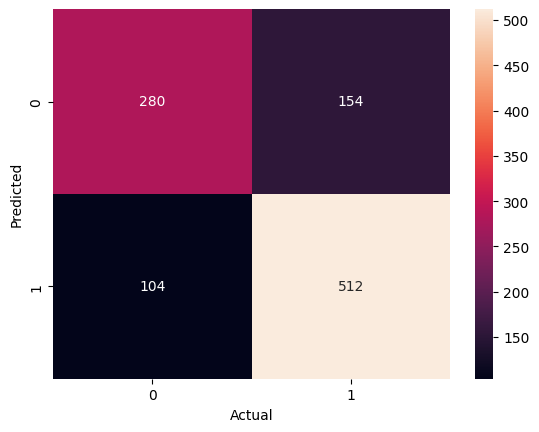

In [15]:
# Evaluation of baseline model (Logistic Regression)
transform_and_scoring(X_train, y_train, baseline)

Classification Report
              precision    recall  f1-score   support

           0     0.6918    0.6250    0.6567       176
           1     0.7732    0.8212    0.7965       274

    accuracy                         0.7444       450
   macro avg     0.7325    0.7231    0.7266       450
weighted avg     0.7414    0.7444    0.7418       450

--------------------------------------------------
ROC AUC score:  0.7230839416058394
--------------------------------------------------
Confusion matrix: 


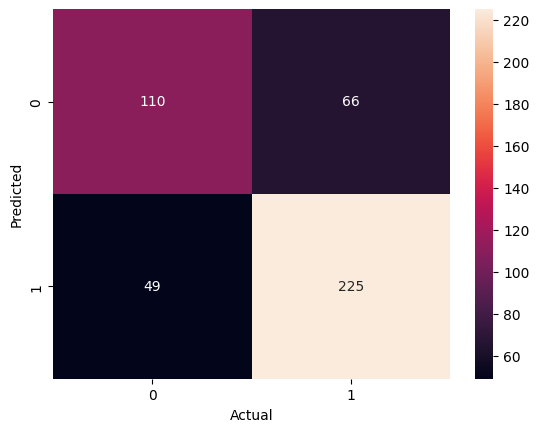

In [16]:
transform_and_scoring(X_test, y_test, baseline)

Classification Report
              precision    recall  f1-score   support

           0     0.7820    0.6613    0.7166       434
           1     0.7848    0.8701    0.8253       616

    accuracy                         0.7838      1050
   macro avg     0.7834    0.7657    0.7709      1050
weighted avg     0.7836    0.7838    0.7803      1050

--------------------------------------------------
ROC AUC score:  0.7657100963552577
--------------------------------------------------
Confusion matrix: 


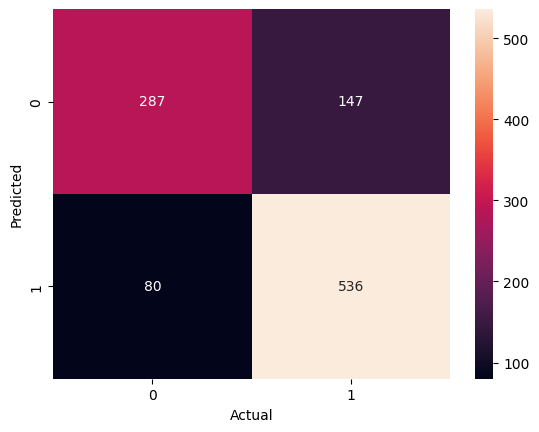

In [17]:
# Evaluation of comparison model (Random Forest)
transform_and_scoring(X_train, y_train, comparison) 

Classification Report
              precision    recall  f1-score   support

           0     0.7292    0.5966    0.6562       176
           1     0.7680    0.8577    0.8103       274

    accuracy                         0.7556       450
   macro avg     0.7486    0.7271    0.7333       450
weighted avg     0.7528    0.7556    0.7501       450

--------------------------------------------------
ROC AUC score:  0.7271275713337757
--------------------------------------------------
Confusion matrix: 


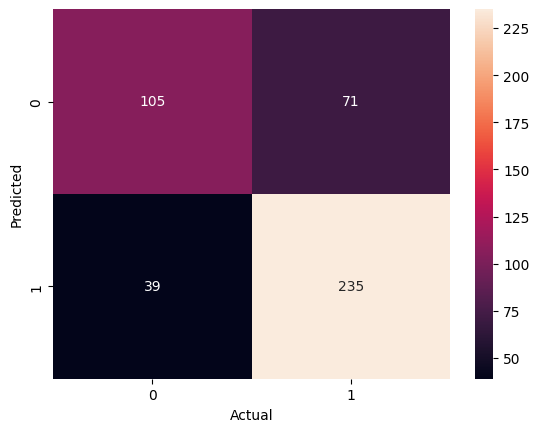

In [18]:
transform_and_scoring(X_test, y_test, comparison) 

## Task 10

Explain which model performs better and why.

_My answer:_

I have used 3 metrics for comparison: accuracy, F1-score and ROC AUC score. Comparing between baseline and comparison model:

- Accuracy: 
    - The baseline model gets 75.43% in training set, 74.44% in test set.
    - The comparison model gets 78.38% in training set, 75.56% in test set.
    - **Comparison model gets higher score in this metric.**

- F1-score:
    - The baseline model gets 74.17% in training set, 72.66% in test set.
    - The comparison model gets 77.09% in training set, 73.33% in test set.
    - **Comparison model gets higher score in this metric.**

- ROC AUC score:
    - The baseline model gets 0.7381 in training set, 0.7230 in test set.
    - The comparison model gets 0.6758 in training set, 0.7271 in test set.
    - **Comparison model gets higher score in this metric.**

In general, the comparison model (Random Forest) performs better which gets higher evaluation in all the metrics.